<img src="images/best-star-wars-planets.webp" width="100%" style="margin-left:auto; margin-right:auto">

<br>

# Project 2

DATA 620
Bonnie Cooper, George Cruz Deschamps, Rob Hodde.

<br>

## Assignment Information

* Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
* Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
* What can you infer about each of the distinct groups?
 

<br>

## Environment

In [2]:
import pandas as pd
import pickle
from pathlib import Path
import urllib
from tqdm import tqdm
import os
import networkx as nx
import matplotlib.pyplot as plt
import sqlalchemy

In [2]:
#!pip install ipython-sql
%load_ext sql

<br>

## Identify and load the Wookieepedia network dataset

For this assignment we will be visualizing a Star Wars data set. This dataset was generated by Dennis Bakhuis from web scrapings of the Wookieepedia website. [Wookieepedia](https://starwars.fandom.com/wiki/Main_Page) is the Star Wars wiki page which serves as an online encyclopedia for any and all things about the Star Wars universe. A full description of Dennis's methods are available on [his github](https://github.com/dennisbakhuis/wookieepediascience).  

### Star Wars network Nodes

To begin, we will load a dataframe of Star Wars characters. These charcters will eventually become the nodes of the Star Wars network:

In [3]:
# read in the StarWars_Characters dataframe
characters = pd.read_parquet('data/parquet/StarWars_Characters.parquet')

In [4]:
print( characters.shape )
characters.head()

(5334, 14)


,name,key,url,description,species_2nd,species_3rd,species,home_world,gender,height,eye_color,skin_color,hair_color,weight
0,1138 (First Order),1138_(First_Order),https://starwars.fandom.com/wiki/1138_(First_O...,1138 was a human male stormtrooper who served ...,None,None,Human,None,Male,NaN,None,None,None,None
1,1151,1151,https://starwars.fandom.com/wiki/1151,1151 was a clone cadet who was a part of the C...,None,None,Human,Kamino,Male,NaN,Brown,Tan,Black,None
2,1174,1174,https://starwars.fandom.com/wiki/1174,"1174, nicknamed ""Whiplash,"" was a clone troope...",None,None,Human,Kamino,Male,NaN,Brown,Tan,Black,None
3,224 (Coruscant Security Force),224_(Coruscant_Security_Force),https://starwars.fandom.com/wiki/224_(Coruscan...,224 was the designation of a human male office...,None,None,Human,None,Male,NaN,None,Light,None,None
4,3-6,3-6,https://starwars.fandom.com/wiki/3-6,3-6 was a male death trooper in DT-F16's squad...,None,None,Human,None,Male,NaN,None,None,None,None


<br>  

### Star Wars network edges

Next, we will repeat the data cleansing process from Project 1 to access each character's Crosslinks:

In [4]:
# go through 6 different pickle files downloaded from Dennis' github
files = sorted(Path('data/pickles').glob('*.pickle'))
data = {}
# for each of the 6 files: open, read & add to the data dictionary
for fn in files:
    with open(fn, 'rb') as f:
        part = pickle.load(f)
    data.update(part)

# a helper function to format urls
def remove_url_shizzle(text):
    return urllib.parse.unquote(text).replace('"', '').replace("'", '')

cleaned = {}
#for every key/value pair in data
for key, value in tqdm(data.items()):
    #let's make a niver to read key
    new_key = remove_url_shizzle(key)
    #set value (a dict) as the values for the new cleaned key
    cleaned[new_key] = value
    #format the 'crosslinks' key
    cleaned[new_key]['crosslinks'] = [remove_url_shizzle(crosslink) for crosslink in value['crosslinks']]
data = cleaned

100%|██████████| 29860/29860 [00:00<00:00, 51440.69it/s]


Here are the number of record and list of keys in the data dictionary:

In [6]:
print('Total records in dictionary:', len(data.keys()))
print('Keys:', data['Yoda'].keys() )

Total records in dictionary: 29858
Keys: dict_keys(['url', 'title', 'is_character', 'side_bar', 'paragraph', 'crosslinks'])


Here are the Crosslinks for the character Yoda:

In [7]:
print(data['Yoda']['crosslinks'])

['The_Gathering', 'Behavioral_modification_biochip', 'Akar-Deshu', 'CT-5555', 'Alliance_to_Restore_the_Republic', 'Chewbacca', 'Darth', 'Ezra_Bridger', 'Jedi', 'Army', 'Starlight_Beacon', 'Immortality', 'Jedi_Knight', 'Nightsisters', 'Skywalker_family', 'Lothal', 'Veter', 'Swamp', 'Count', 'Cloning', 'Huyang', 'Battle_of_Endor', 'Separatist_Droid_Army', 'Kamino', 'Kashyyyk', 'Mandalorian', 'Homeworld', 'Mission_to_Raxus', 'Cave_of_Evil', 'CC-4477', 'Yodas_species', 'Medical_droid', 'Jabba_Desilijic_Tiure', 'Zillo_Beast', 'Second_battle_of_Christophsis', 'Millennium', 'Even_Piell', 'Coleman_Trebor', 'Gas_giant', 'Seeing_stone', 'New_Order', 'Silman', 'Rig_Nema', 'Siege_of_Mandalore', 'Tiplar', 'Battle_of_Kashyyyk', 'Galactic_Empire', 'Obi-Wan_Kenobi', 'Kachirho', 'Force-bond', 'Hutt', 'Bombing_of_the_Jedi_Temple_hangar', 'Plo_Koon', 'Jetpack', 'Firefly', 'Light_side_of_the_Force', '4_ABY', 'Battle_of_Crait', 'Telekinesis', 'Canon', 'Lothal_Jedi_Temple', 'Sith_Lord', 'Letta_Turmond', 'Mi

<br>  

### Star Wars Planets

For Project 2, we want to find **planets** in the Crosslinks, so that we can attach Star Wars characters to Star Wars planets, and create a bipartite graph of Characters And Planets.

But how do we find planetary data? We must study the Star Wars Canon pickle files again.

As an aside, sometimes data engineers must build integrations between Python scripts and on-premise SQL databases, so we will demonstrate one integration method in this section.

The code block below moves the pickle files into the database: 

In [5]:
## copy the pickle files to MS SQL 
sw = sorted(Path('data/pickles').glob('*.pickle'))
#params = urllib.parse.quote_plus(r'DRIVER={SQL Server};SERVER=DESKTOP-FD4H0K5;DATABASE=CUNY;Trusted_Connection=yes')
#conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(params)
conn_str='sqlite:///data/db1.db'
engine = sqlalchemy.create_engine(conn_str)

print(str(engine))
for i in sw:
   filename = os.path.split(i)[-1]
   d = pd.read_pickle(i) #read pickle into data dictionary
   df = pd.DataFrame.from_dict(d, orient='index').reset_index(drop=False)
   #convert all columns to strings and write to MS SQL
   df.astype(str).to_sql(name=filename,con=engine, if_exists='append',index=False) 
   

Engine(sqlite:///data/db1.db)


Below is a sample of the last pickle file converted to a dataframe:

In [9]:
df.head()

,index,url,title,is_character,side_bar,paragraph,crosslinks
0,The_Grand_Inquisitor%27s_lightsaber,https://starwars.fandom.com/wiki/The_Grand_Inq...,The Grand Inquisitor's lightsaber,False,{'Production information': {'Model': 'Double-b...,The Grand Inquisitor's lightsaber was the pers...,"[Mustafar_system, Jedi_hunter, Order_66, Cumbe..."
1,The_Grievous_Legion,https://starwars.fandom.com/wiki/The_Grievous_...,The Grievous Legion,False,{'General information': {'Formation type': 'Ba...,The Grievous Legion was a battle group in the ...,"[Salissian_special_forces, Corporate_Alliance_..."
2,The_Hammer_of_Ryloth,https://starwars.fandom.com/wiki/The_Hammer_of...,The Hammer of Ryloth,False,{},"""The Hammer of Ryloth"" was a title earned by t...","[Twi%27lek, Battle_of_Ryloth, General, Cham_Sy..."
3,The_Harch,https://starwars.fandom.com/wiki/The_Harch,The Harch,True,"{'Physical description': {'Species': 'Harch', ...","""The Harch"" was the nickname of a female Harch...","[Battle_of_Endor, Sexes, Galactic_Empire, Spac..."
4,The_Haunted_Lands,https://starwars.fandom.com/wiki/The_Haunted_L...,The Haunted Lands,False,{'General information': {'Location': 'Dathomir...,The Haunted Lands were a region of the planet ...,"[Oteroa_Zero-Twenty, Dathomir, Planet, Canon]"


Here is a screen capture of the new SQL Database tables taken from SQL Server Management Studio:


<img src="images/SQL-Pickle-Tables.png" width="33%" style="margin-left:auto; margin-right:auto">


Below is a screenshot of a few records from one of the converted pickle tables:



<img src="images/SQL-Pickle-Rows.png" width="100%" style="margin-left:auto; margin-right:auto">


In [10]:
%%sql sqlite:///data/db1.db
DROP TABLE IF EXISTS [starwars_all_canon_data];


Done.


[]

We combine the six tables into one:

<img src="images/SQL-Pickle-Combine.png" width="33%" style="margin-left:auto; margin-right:auto">


In [11]:
%%sql sqlite:///data/db1.db
create table [starwars_all_canon_data] as
select * from [starwars_all_canon_data_1.pickle] union
select * from [starwars_all_canon_data_2.pickle] union
select * from [starwars_all_canon_data_3.pickle] union
select * from [starwars_all_canon_data_4.pickle] union
select * from [starwars_all_canon_data_5.pickle] union
select * from [starwars_all_canon_data_6.pickle]

Done.


[]

Since we are looking for planets, we can query on the name of a known planet. Note the "Sidebar" column contains "Astrological information" and the Paragraph contains the word "planet".  We will use this as a starting point to search for planets. 

<img src="images/Canon-Jakku.png" width="60%" style="margin-left:auto; margin-right:auto">

We add column "ObjectType" to store our classifications. This helps if some must be classified manually due to dirty data.



<img src="images/Canon-ObjectType.png" width="70%" style="margin-left:auto; margin-right:auto">

The ObjectType column also helps us declassify "false matches":

<img src="images/Astro-NotPlanets.png" width="70%" style="margin-left:auto; margin-right:auto">

**OK, that's enough SQL!   How to get the data back to Python?**  

We save it as a parquet!

In [ ]:
import pyodbc
import fastparquet

# define the database connection
# sServer = 'localhost'
# sDB = 'CUNY'
# cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
#                      "Server=" + sServer + ";"
#                      "Database=" + sDB + ";"
#                      "Trusted_Connection=yes;")  

#export list of 826 planets from SQL to parquet
sSQL = "SELECT ObjectName Name FROM tbl_StarWars_Canon WHERE ObjectType = 'Planet'" # query
df = pd.read_sql_query(sSQL, engine) #read the SQL data into a pandas dataframe
df.to_parquet('StarWars_Canon_All_Planets.parquet', engine='fastparquet') #convert the dataframe to a parquet file

# We also made a medium-sized list of planets, sourced from https://en.wikipedia.org/wiki/List_of_Star_Wars_planets_and_moons
sSQL = "SELECT Name FROM tbl_StarWars_Planets" 
df = pd.read_sql_query(sSQL, engine)
df.to_parquet('StarWars_Planets.parquet', engine='fastparquet')

# We also made a small list of planets, sourced from https://screenrant.com/star-wars-rogue-one-planets-ranked-jedha-scarif-tatooine/
sSQL = "SELECT Name FROM tbl_StarWars_Planets WHERE Description2 IS NOT NULL" 
df = pd.read_sql_query(sSQL, engine)
df.to_parquet('StarWars_Planets_Shortlist.parquet', engine='fastparquet')


We see the parquet files now in our Github repo directory:


<img src="images/Planets-Parquets.png" width="50%" style="margin-left:auto; margin-right:auto">




<br>  
Next we want to join our Star Wars characters to Star Wars Planets.  We read the parquets into lists:

In [6]:
characters_list = pd.read_parquet('data/parquet/StarWars_Characters.parquet')['key'].tolist()

df = pd.read_parquet('data/parquet/StarWars_Canon_All_Planets.parquet') 
planets_large_list = df['Name'].to_list()

df = pd.read_parquet('data/parquet/StarWars_Planets.parquet') 
planets_medium_list = df['Name'].to_list()

df = pd.read_parquet('data/parquet/StarWars_Planets_Shortlist.parquet') 
planets_short_list = df['Name'].to_list()


<br>  

### Graph Objects: Characters and Planets

Next we will create a network graph object, linking all Star Wars characters to all planets: 

In [7]:
#create a graph object for all characters, all planets
graph_large = nx.Graph()
#loop thru each character
for key in tqdm(characters_list):  #tqdm = progress bar
    #use this key from characters to get the crosslinks from data
    crosslinks = data[key]['crosslinks']
    for crosslink in crosslinks:
        # if the crosslink is to a planet, 
        # then this connection describes a connection between a character and a planet
        if crosslink in planets_large_list:
            # add to the .Graph object
            graph_large.add_edge(key, crosslink)
        
print(f'Nodes: {graph_large.number_of_nodes()}, Links: {graph_large.number_of_edges()}')      

100%|██████████| 5334/5334 [00:01<00:00, 3047.84it/s]

Nodes: 4224, Links: 7927


Here are the first ten nodes (characters):

In [12]:
# list a few nodes
print(list(graph_large.nodes)[:10] )


['1138_(First_Order)', 'Jakku', '1151', 'Kamino', '1174', '224_(Coruscant_Security_Force)', 'Coruscant', '3-9', 'Lothal', '7173']


Here are the planets associated with the character Saw Gerrera:

In [16]:
# list edges for one character - these are the planets associated with that character
print(graph_large.edges('Saw_Gerrera') )

[('Saw_Gerrera', 'Kashyyyk'), ('Saw_Gerrera', 'Jedha'), ('Saw_Gerrera', 'Jeosyn'), ('Saw_Gerrera', 'Onderon'), ('Saw_Gerrera', 'Yerbana'), ('Saw_Gerrera', 'Alderaan'), ('Saw_Gerrera', 'Agamar'), ('Saw_Gerrera', 'Geonosis'), ('Saw_Gerrera', 'Serenno'), ('Saw_Gerrera', 'Inusagi'), ('Saw_Gerrera', 'Core_Worlds'), ('Saw_Gerrera', 'Wrea'), ('Saw_Gerrera', 'Coruscant')]


Next we need to integrate the "Sith" and "Jedi" (Bad/Good) polarity into the dataset, so that we can create a bipartite graph

Sith = bipartite=0
Jedi = bipartite=1



In [8]:
affiliations_scores = pd.read_csv( 'data/affiliation_scores.csv' )
# recast the columns as a python dict
aff_dict = {affiliations_scores['Organization'][i]: affiliations_scores['Score'][i] for i in range(len(affiliations_scores['Organization']))}

# functionalize getting the score
def calc_affiliation_score( affiliation_entry, scores_dict ):
    """
    this function will take the dictionary value for either 'Affiliation' of 'Affiliation(s)' 
    from the 'Chronological and political information' field.
    will evaluate whether the entry is a string or list of strings
    will then calculate the node's score as the mean of the affiliation scores 
    """
    if isinstance(affiliation_entry, str):
        score = scores_dict[ affiliation_entry ]
    elif type(affiliation_entry)==list and len(affiliation_entry)>=2:
        scores = [scores_dict[entity] for entity in affiliation_entry]
        score = sum( scores )/len(scores)
    else:
        score = float("NaN")
        
    return score

#functionalize assigning the outcome
def cal_affiliation( score ):
    if score == 0:
        res = 'neutral'
    elif score > 0:
        res = 'good'
    elif score < 0:
        res = 'bad'
    return res

data_keys = list( data.keys() )
#affiliations = []
for node in graph_large.nodes:
    if node in data_keys:
        try: 
            aff_key = ""
            if 'Affiliation' in data[node]['side_bar']['Chronological and political information']:
                aff_key = 'Affiliation'
            elif 'Affiliation(s)' in data[node]['side_bar']['Chronological and political information']:
                aff_key = 'Affiliation(s)'

            score = 0
            if aff_key != "":
                affiliations = data[node]['side_bar']['Chronological and political information'][aff_key]
                score = calc_affiliation_score( affiliations, aff_dict )
            graph_large.nodes[node]['score'] = round( score, 2 )
            graph_large.nodes[node]['alignment'] = cal_affiliation( score )
        except:
            score = float("NaN")
            graph_large.nodes[node]['score'] = score
            graph_large.nodes[node]['alignment'] = 'neutral'

nx.write_gpickle(graph_large, "data/pickles/sw_large_affiliations.gpickle")

### A Bipartite Graph

We can then take a look at the bipartite graph between characters and planets.

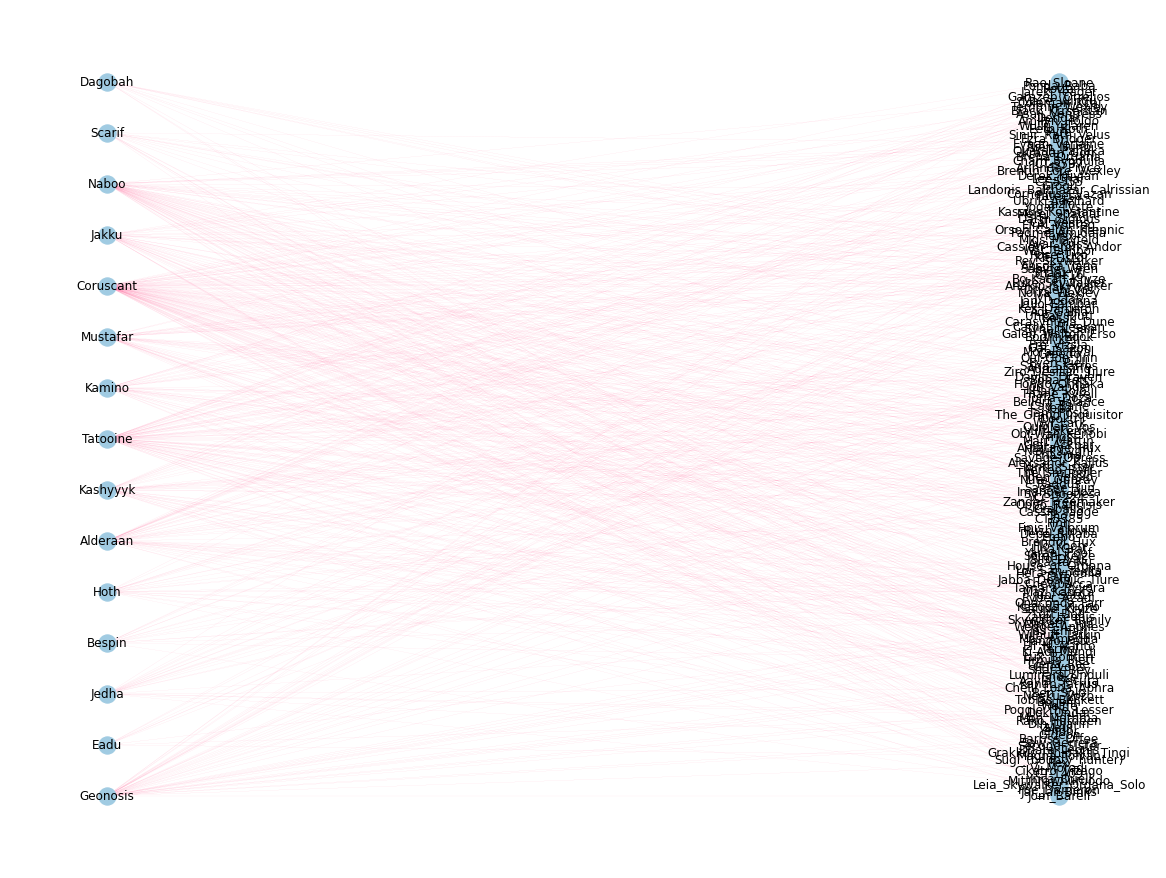

In [20]:
from networkx.algorithms import bipartite
smallG = nx.read_gpickle('data/pickles/SW_affiliations.gpickle')
lConnections = sorted(smallG.degree, key=lambda x: x[1], reverse=True) #create a sorted list of characters by number of connections

planets=[]
characters=[]
planets_characters_edges=[]
#build each list of contributors (source) and politicians (candidate), and their linkages
for i, connection in enumerate(lConnections[:200]):
    node = connection[0]
    if node in characters_list:
        characters.append(node) #Character
        crosslinks = data[node]['crosslinks']
        for crosslink in crosslinks:
            # if the crosslink is to a planet, 
            # then this connection describes a connection between a character and a planet
            if crosslink in planets_short_list:
                # add to the .Graph object
                planets.append(crosslink)
                planets_characters_edges.append([node, crosslink])

G = nx.Graph()
G.add_nodes_from(planets, bipartite=0)
G.add_nodes_from(characters,bipartite=1)
G.add_edges_from(planets_characters_edges)
bipartite.is_bipartite(G)
plt.figure(figsize=(16,12)) 

# First specify the nodes you want on left or top
left_or_top = planets
# Then create a bipartite layout
pos = nx.bipartite_layout(G, left_or_top)
# Pass that layout to nx.draw
nx.draw(G,pos,node_color='#A0CBE2',
        edge_color='#FF005E',width=.03,
        edge_cmap=plt.cm.Blues,with_labels=True)
# Get the edge labels for ratings
edge_labels = nx.get_edge_attributes(G,'Character')
# Draw the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


#nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, planets), width = 0.2)
plt.show()


#### Characters Network

Now that we have a graph object, let's evaluate the different components.  Let's compute an affiliation network of the Characters:

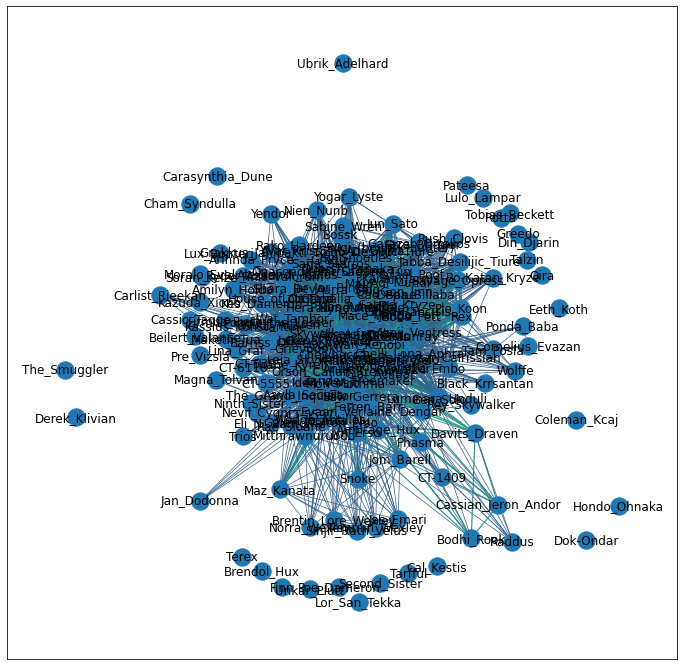

In [23]:
import math
character_nets=bipartite.weighted_projected_graph(G, characters, ratio=False)
character_net= [character_nets.subgraph(c).copy() for c in nx.connected_components(character_nets)][0]

weights=[math.log(edata['weight']) for f,t,edata in character_net.edges(data=True)]

plt.figure(figsize=(12,12)) 
nx.draw_networkx(character_net,width=weights, edge_color=weights)
plt.show()

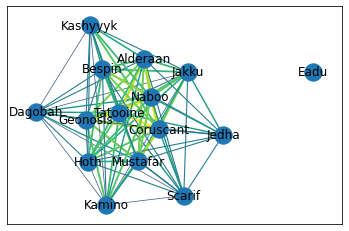

In [93]:
planet_nets=bipartite.weighted_projected_graph(G, planets, ratio=False)
planet_net= [planet_nets.subgraph(c).copy() for c in nx.connected_components(planet_nets)][0]

weights=[math.log(edata['weight']) for f,t,edata in planet_net.edges(data=True)]
nx.draw_networkx(planet_net,width=weights, edge_color=weights)

(array([34., 29., 21.,  0., 14., 13.,  0., 12.,  0.,  1.]),
 array([ 3. ,  3.7,  4.4,  5.1,  5.8,  6.5,  7.2,  7.9,  8.6,  9.3, 10. ]),
 <BarContainer object of 10 artists>)

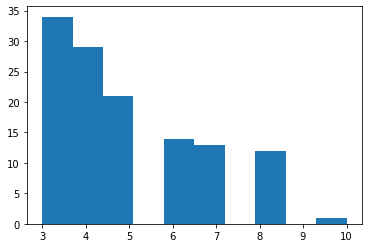

In [109]:
def trim_edges(g, weight=1):
  g2=nx.Graph()
  for f, to, edata in g.edges(data=True):
    if edata['weight'] > weight:
      g2.add_edge(f,to,weight=edata['weight'])
  return g2

plt.hist(weights)

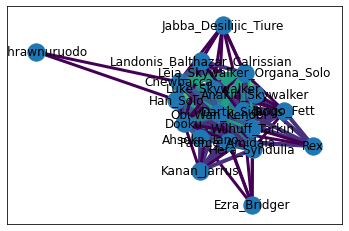

In [110]:
## The weights histogram is logarithmic;
## we should compute the original weight = e^log_weight
character_net_trim=trim_edges(character_net, weight=math.exp(0.9))
## re-calculate weights based on the new graph
weights = []
for f,t,edata in character_net_trim.edges(data=True):
  weights.append(edata['weight'])
nx.draw_networkx(character_net_trim,width=weights, edge_color=weights)